In [31]:
# basic imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from unyt import kW, minute, hour, day, MW, kg, lb, kWh, MWh
import sys

# osier imports
from osier import CapacityExpansion
import osier.tech_library as lib
from osier.equations import total_cost, annual_emission, annual_co2
from osier import get_tech_names

# import megatonnes from unyt -- must be done after importing osier
from unyt import megatonnes

# pymoo imports
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.pcp import PCP
from functools import partial


# set the solver based on operating system -- assumes glpk or cbc is installed.
if "win32" in sys.platform:
    solver = 'glpk'
elif "linux" in sys.platform:
    solver = "appsi_highs"
else:
    solver = "appsi_highs"

print(f"Solver set: {solver}")

Solver set: appsi_highs


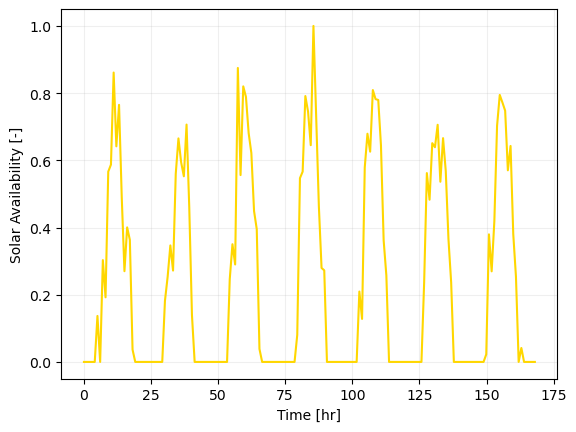

In [42]:
n_hours = 24  # hours per day
n_days = 7  # days to model
N = n_hours*n_days  # total number of time steps
phase_shift = np.pi/2  # horizontal shift [radians]
base_shift = 2  # vertical shift [units of demand]
hours = np.linspace(0,N,N)

solar_cp = (-np.sin((hours*np.pi/n_hours*2+phase_shift)))
# solar[solar<0] = 0

rng = np.random.default_rng(1234)

solar_cp += rng.normal(size=N)*15e-2
solar_cp[solar_cp<0] = 0

solar_cp = solar_cp/solar_cp.max()  # rescale


demand = np.ones(N)*1e3*MW
# print(demand)


# with plt.style.context("dark_background"):
#     plt.plot(hours, solar_cp, color='gold')
#     plt.ylabel('Solar Availability [-]')
#     plt.xlabel('Time [hr]')
#     plt.grid(alpha=0.2)
#     plt.show()


plt.plot(hours, solar_cp, color='gold')
plt.ylabel('Solar Availability [-]')
plt.xlabel('Time [hr]')
plt.grid(alpha=0.2)
plt.show()

In [3]:
peak_demand = 1e3*MW 
demand = np.ones(N)*peak_demand

In [4]:
natural_gas = lib.natural_gas
natural_gas_adv = lib.natural_gas_adv
nuclear_ap1000 = lib.nuclear
nuclear_smr = lib.nuclear_adv
solar = lib.solar
battery = lib.battery

In [5]:
emission_df = pd.read_html("https://www.eia.gov/tools/faqs/faq.php?id=74&t=11")[0].droplevel(1, axis=1).set_index('Unnamed: 0_level_0').iloc[:-1,:-2]
emission_df.columns = ['Total kWh', 'Total CO2 million mt', 'million short tons','lbs per kWh']
emission_df.index.name = ''
emission_df

,Total kWh,Total CO2 million mt,million short tons,lbs per kWh
,,,,
Coal,675115,709,781,2.31
Natural gas,1806063,790,871,0.96
Petroleum,16233,18,20,2.46
All other energy sources,4183271,1532,1688,0.81


In [6]:
eroi_df = pd.read_csv("../../../data/eroi_data.csv", index_col=0)
eroi_df

,EROIstd
Generation method,
Natural Gas (CCGT),89.0
Natural Gas (CCGT & CCS),12.4
"Solar PV (Mono-Si, SE-med)",2.5
Nuclear (83% centrifuge),69.6
Nuclear (100% centrifuge),96.2


In [7]:
final_techs = {'Utility PV - Class 1':'UtilityPV', 
    'NG 1-on-1 Combined Cycle (H-Frame)':"Natural Gas",
    'NG 1-on-1 Combined Cycle (H-Frame) 95% CCS':"Natural Gas CCS",
    'Nuclear - Large':"Nuclear",
    'Nuclear - Small':"Advanced Nuclear",        
    'Utility-Scale Battery Storage - 4Hr':"Battery",
    }

In [8]:
cost_df = pd.read_csv("../../../data/technology_costs.csv", index_col=['core_metric_parameter','display_name'])
cost_df

value
core_metric_parameter display_name                 
Fixed O&M             UtilityPV           16.798551
CAPEX                 UtilityPV         1074.217024
Fixed O&M             Natural Gas         37.000000
                      Natural Gas CCS     66.100000
Variable O&M          Natural Gas          2.390000
                      Natural Gas CCS      4.620000
CAPEX                 Natural Gas       1645.344968
                      Natural Gas CCS   2916.043828
Fixed O&M             Nuclear            175.000000
                      Advanced Nuclear   136.000000
Variable O&M          Nuclear              2.800000
                      Advanced Nuclear     2.600000
CAPEX                 Nuclear           7486.164800
                      Advanced Nuclear  8935.185812
Fixed O&M             Battery             31.501211
CAPEX                 Battery           1409.745888

In [9]:
# for a NG 1-on-1 H Frame design
natural_gas.co2_rate = (float(emission_df.at['Natural gas', 'lbs per kWh'])*lb/kWh).to(megatonnes/MWh)
natural_gas.capital_cost = cost_df.at[('CAPEX','Natural Gas'), 'value'] / kW
natural_gas.om_cost_variable = cost_df.at[('Variable O&M','Natural Gas'), 'value'] / MWh
natural_gas.om_cost_fixed = cost_df.at[('Fixed O&M','Natural Gas'), 'value'] / kW
natural_gas.eroi = eroi_df.at['Natural Gas (CCGT)', 'EROIstd'] # from Walmsley et al.
# same design, with 95% CCS
natural_gas_adv.co2_rate = natural_gas.co2_rate * 0.05
natural_gas_adv.capital_cost = cost_df.at[('CAPEX','Natural Gas CCS'), 'value'] / kW
natural_gas_adv.om_cost_variable = cost_df.at[('Variable O&M','Natural Gas CCS'), 'value'] / MWh
natural_gas_adv.om_cost_fixed = cost_df.at[('Fixed O&M','Natural Gas CCS'), 'value'] / kW
natural_gas_adv.eroi = eroi_df.at['Natural Gas (CCGT & CCS)', 'EROIstd'] # from Walmsley et al.

In [10]:
# utility scale solar, with good insolation, middling estimate
solar.capital_cost = cost_df.at[('CAPEX','UtilityPV'), 'value']/kW
solar.eroi = eroi_df.at['Solar PV (Mono-Si, SE-med)', 'EROIstd'] # from Walmsley et al. 2018
solar.om_cost_fixed = cost_df.at[('Fixed O&M','UtilityPV'), 'value']/kW

In [11]:
battery.capital_cost = cost_df.at[('CAPEX','Battery'), 'value'] / kW
battery.om_cost_fixed = cost_df.at[('Fixed O&M','Natural Gas'), 'value']/ kW
battery.eroi = 10  # actually an 'ESOI,' from Barnhart and Benson 2013

In [12]:
nuclear_ap1000.capital_cost = cost_df.at[('CAPEX','Nuclear'), 'value'] / kW
nuclear_ap1000.om_cost_fixed = cost_df.at[('Fixed O&M','Nuclear'), 'value'] / kW
nuclear_ap1000.om_cost_variable = cost_df.at[('Variable O&M','Nuclear'), 'value'] 
nuclear_ap1000.eroi = eroi_df.at['Nuclear (100% centrifuge)', 'EROIstd']

nuclear_smr.capital_cost = cost_df.at[('CAPEX','Advanced Nuclear'), 'value']
nuclear_smr.om_cost_fixed = cost_df.at[('Fixed O&M','Advanced Nuclear'), 'value']/ kW
nuclear_smr.om_cost_variable = cost_df.at[('Variable O&M','Advanced Nuclear'), 'value']/ MWh
nuclear_smr.eroi = eroi_df.at['Nuclear (100% centrifuge)', 'EROIstd']

In [13]:
tech_list = [natural_gas, natural_gas_adv, solar, battery, nuclear_ap1000, nuclear_smr]

In [14]:
def eroi_objective(technology_list, solved_dispatch_model):
    """
    Calculate the objective to ``maximize'' the Energy Return on Investment (EROI)
    by minimizing its inverse.
    """
    weighted_eroi = np.array([t.capacity.to_value() * t.eroi for t in technology_list]).sum()
    obj_value = 1/weighted_eroi
    return obj_value

In [15]:
solar.capacity_credit

0.19

In [25]:
problem = CapacityExpansion(technology_list=tech_list,
                            demand=demand,
                            solar=solar_cp,
                            upper_bound = 1 / solar.capacity_credit,
                            objectives = [total_cost, 
                                         partial(annual_emission, emission='co2_rate'),
                                         eroi_objective],
                            solver=solver
                            )

In [38]:
%%time
res = minimize(problem,
               NSGA2(pop_size=100),
               termination=('n_gen', 20),
               seed=1,
               save_history=True,
               verbose=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     27 |             - |             -
     2 |      200 |     49 |  0.0117448610 |         ideal
     3 |      300 |     79 |  0.0438121891 |         ideal
     4 |      400 |    100 |  0.0028444875 |         ideal
     5 |      500 |    100 |  0.0048029066 |         ideal
     6 |      600 |    100 |  0.0081316097 |         ideal
     7 |      700 |    100 |  0.0138053612 |         ideal
     8 |      800 |    100 |  0.0573052300 |         nadir
     9 |      900 |    100 |  0.0441646984 |         nadir
    10 |     1000 |    100 |  0.0093329289 |             f
    11 |     1100 |    100 |  0.0066443165 |         ideal
    12 |     1200 |    100 |  0.0094066339 |         ideal
    13 |     1300 |    100 |  0.0117132059 |             f
    14 |     1400 |    100 |  0.0133683966 |             f
    15 |     1500 |    100 |  0.0130531491 |             f
    16 |     1600 |    100 |  0.0131128645 |            

/Users/samdotson/miniforge3/envs/2025-dotson-thesis-2/lib/python3.12/site-packages/pymoo/core/plot.py:123: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(**kwargs)


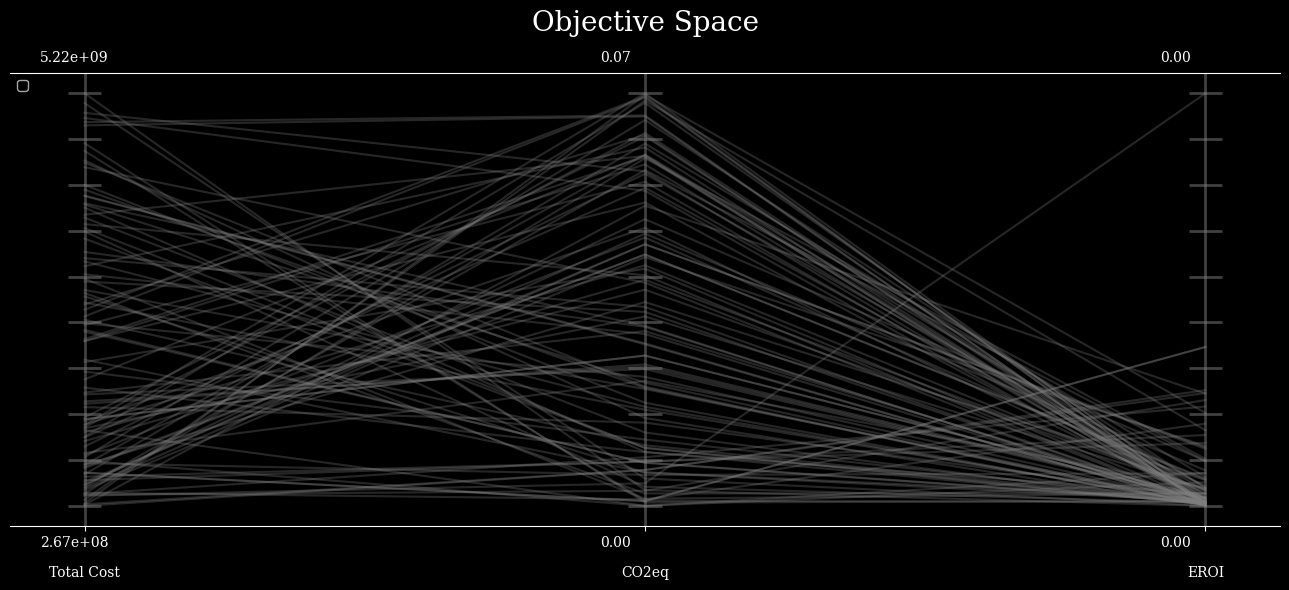

In [39]:
obj_labels=['Total Cost', 'CO2eq', 'EROI']
with plt.style.context('dark_background'):
    plot = PCP(title=("Objective Space", {'pad': 30, 'fontsize':20}),
            n_ticks=10,
            legend=(True, {'loc': "upper left"}),
            labels=obj_labels,
            figsize=(13,6),
            )

    plot.set_axis_style(color="grey", alpha=0.5)
    plot.tight_layout = True
    plot.add(res.F, color="grey", alpha=0.3)

    # plot.add(res.F[3], linewidth=5, color="tab:green", label=r"Least CO$_2$")
    # plot.add(res.F[6], linewidth=5, color="tab:blue", label="Least Cost")
    plot.show()
    plt.show()

/Users/samdotson/miniforge3/envs/2025-dotson-thesis-2/lib/python3.12/site-packages/pymoo/core/plot.py:123: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(**kwargs)


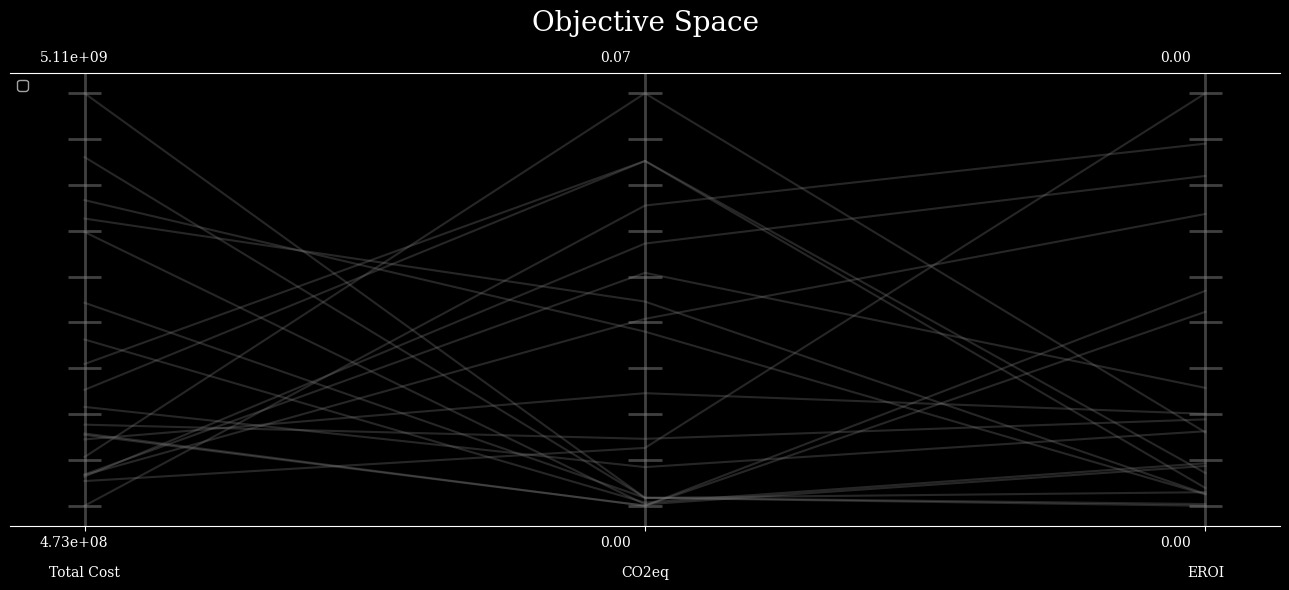

In [29]:
obj_labels=['Total Cost', 'CO2eq', 'EROI']
with plt.style.context('dark_background'):
    plot = PCP(title=("Objective Space", {'pad': 30, 'fontsize':20}),
            n_ticks=10,
            legend=(True, {'loc': "upper left"}),
            labels=obj_labels,
            figsize=(13,6),
            )

    plot.set_axis_style(color="grey", alpha=0.5)
    plot.tight_layout = True
    plot.add(res.F, color="grey", alpha=0.3)

    # plot.add(res.F[3], linewidth=5, color="tab:green", label=r"Least CO$_2$")
    # plot.add(res.F[6], linewidth=5, color="tab:blue", label="Least Cost")
    plot.show()
    plt.show()

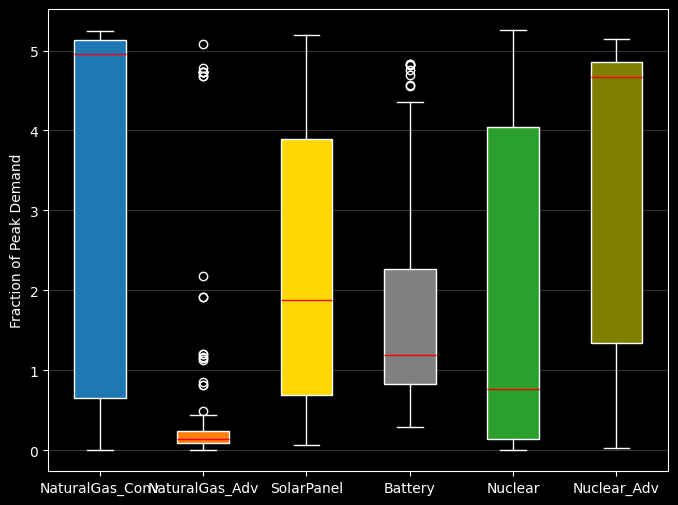

In [ ]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=(8,6))

    bplot = ax.boxplot(res.X,
                       patch_artist=True,
                       tick_labels=get_tech_names(problem.technology_list))
    ax.set_ylabel("Fraction of Peak Demand")

    # fill with colors
    colors = ['tab:blue', 'tab:orange', 'gold','gray','tab:green','olive']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    for median in bplot['medians']:
        median.set_color('red')

    ax.yaxis.grid(True, alpha=0.2)
    plt.show()